# Imports

In [82]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf

In [83]:
df=pd.read_csv('data/citibike_2023.csv')

C:\Users\ysc15\AppData\Local\Temp\ipykernel_6008\1007777399.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('data/citibike_2023.csv')


In [84]:
df.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,12536574,6A1558E5EB8E9B3B,classic_bike,2023-06-25 06:44:47,2023-06-25 07:02:43,Walton Ave & E 168 St,8179.03,Icahn Stadium,7514.01,40.836655,-73.918324,40.793460,-73.923890,member
1,20766033,F5DAABF8EAD39B32,classic_bike,2023-08-15 18:05:37,2023-08-15 18:12:06,Grand Army Plaza & Central Park S,6839.10,2 Ave & E 72 St,6925.09,40.764004,-73.973974,40.768762,-73.958408,member
2,17246346,CC4D3C1C193EBCDD,classic_bike,2023-07-05 15:00:28,2023-07-05 15:06:34,Knickerbocker Ave & Thames St,5018.06,Melrose St & Broadway,4801.04,40.705446,-73.929975,40.697481,-73.935877,casual
3,3860641,541D7A53817AF238,classic_bike,2023-03-05 11:29:02,2023-03-05 11:36:36,DeKalb Ave & Vanderbilt Ave,4461.04,Pacific St & Classon Ave,4148.07,40.689425,-73.968898,40.679194,-73.958790,member
4,27285265,EACA2B802BFED979,classic_bike,2023-10-17 15:02:23,2023-10-17 15:06:40,Liberty St & Broadway,5105.01,West Thames St,5114.06,40.708164,-74.010369,40.708347,-74.017134,member


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1000000 non-null  int64  
 1   ride_id             1000000 non-null  object 
 2   rideable_type       1000000 non-null  object 
 3   started_at          1000000 non-null  object 
 4   ended_at            1000000 non-null  object 
 5   start_station_name  999459 non-null   object 
 6   start_station_id    999459 non-null   object 
 7   end_station_name    997192 non-null   object 
 8   end_station_id      997192 non-null   object 
 9   start_lat           1000000 non-null  float64
 10  start_lng           1000000 non-null  float64
 11  end_lat             999287 non-null   float64
 12  end_lng             999287 non-null   float64
 13  member_casual       1000000 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 106.8+ MB


# Data Cleanup / Preprocessing

In [86]:
# Remove Null Values
df.dropna(inplace=True)

In [87]:
# Drop unused column
df.drop(['ride_id','rideable_type','member_casual','start_station_name','end_station_name'],axis=1, inplace=True)

In [88]:
# Round the latitude/longitude values
df[['start_lat', 'end_lat', 'start_lng', 'end_lng']] = df[['start_lat', 'end_lat', 'start_lng', 'end_lng']].round(6)
df[['start_lat', 'end_lat', 'start_lng', 'end_lng']] = df[['start_lat', 'end_lat', 'start_lng', 'end_lng']].astype('float32')

In [89]:
# Cast the start/end station id to numbers
df[['start_station_id', 'end_station_id']] = df[['start_station_id', 'end_station_id']].apply(pd.to_numeric, errors='coerce')
df[['start_station_id', 'end_station_id']] = df[['start_station_id', 'end_station_id']].astype('float16')

In [90]:
# Convert to Date/time
df['started_at']=pd.to_datetime(df['started_at'])
df['ended_at']=pd.to_datetime(df['ended_at'])

In [91]:
# Get time of day in terms of percentage
df['start_time'] = (df['started_at'].dt.hour + (df['started_at'].dt.minute / 60)) / 24

# Convert time of day to cyclic features using sine and cosine
df['time_sin'] = np.sin(2 * np.pi * df['start_time'])
df['time_cos'] = np.cos(2 * np.pi * df['start_time'])

In [92]:
# Also consider cyclic day of the week
df['day_sin'] = np.sin(2 * np.pi * df['started_at'].dt.dayofweek / 7)
df['day_cos'] = np.cos(2 * np.pi * df['started_at'].dt.dayofweek / 7)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997021 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        997021 non-null  int64         
 1   started_at        997021 non-null  datetime64[ns]
 2   ended_at          997021 non-null  datetime64[ns]
 3   start_station_id  996970 non-null  float16       
 4   end_station_id    996831 non-null  float16       
 5   start_lat         997021 non-null  float32       
 6   start_lng         997021 non-null  float32       
 7   end_lat           997021 non-null  float32       
 8   end_lng           997021 non-null  float32       
 9   start_time        997021 non-null  float64       
 10  time_sin          997021 non-null  float64       
 11  time_cos          997021 non-null  float64       
 12  day_sin           997021 non-null  float64       
 13  day_cos           997021 non-null  float64       
dtypes: dateti

In [94]:
df.head()

,Unnamed: 0,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,start_time,time_sin,time_cos,day_sin,day_cos
0,12536574,2023-06-25 06:44:47,2023-06-25 07:02:43,8180.0,7516.0,40.836655,-73.918327,40.793461,-73.923889,0.280556,0.981627,-0.190809,-0.781831,0.623490
1,20766033,2023-08-15 18:05:37,2023-08-15 18:12:06,6840.0,6924.0,40.764004,-73.973976,40.768761,-73.958405,0.753472,-0.999762,0.021815,0.781831,0.623490
2,17246346,2023-07-05 15:00:28,2023-07-05 15:06:34,5020.0,4800.0,40.705444,-73.929977,40.697479,-73.935875,0.625000,-0.707107,-0.707107,0.974928,-0.222521
3,3860641,2023-03-05 11:29:02,2023-03-05 11:36:36,4460.0,4148.0,40.689426,-73.968895,40.679195,-73.958794,0.478472,0.134851,-0.990866,-0.781831,0.623490
4,27285265,2023-10-17 15:02:23,2023-10-17 15:06:40,5104.0,5116.0,40.708164,-74.010368,40.708347,-74.017136,0.626389,-0.713250,-0.700909,0.781831,0.623490


# Visualization

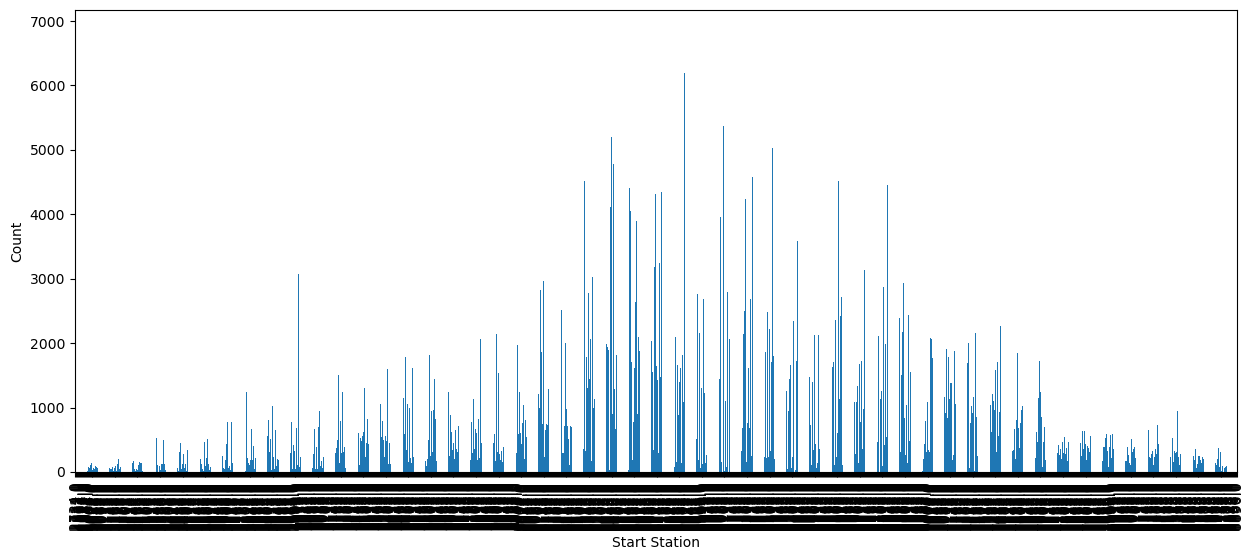

In [95]:
plt.figure(figsize=(15,6))
df['start_station_id'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Start Station")
plt.ylabel("Count")
plt.show()

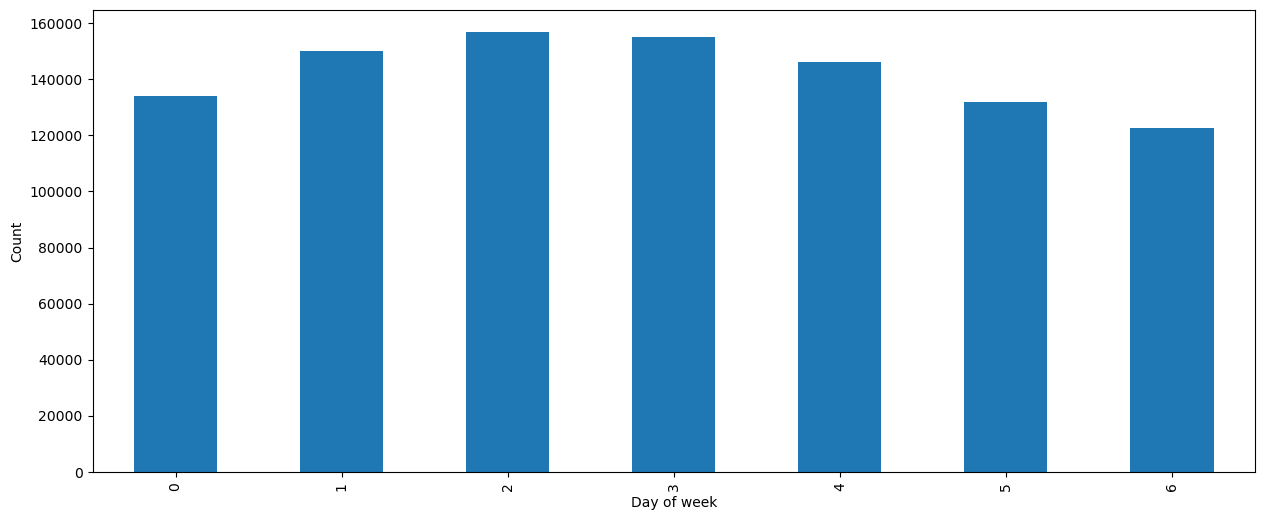

In [96]:
plt.figure(figsize=(15,6))
df['started_at'].dt.dayofweek.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Day of week")
plt.ylabel("Count")
plt.show()

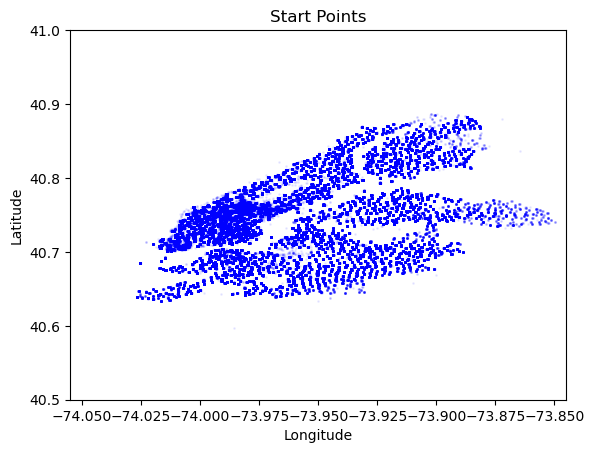

In [97]:
x = df['start_lng']
y = df['start_lat']
plt.scatter(x, y, s = 1, color = '#0000FF11')
plt.xlim(-74.055,-73.845)
plt.ylim(40.5,41)
plt.title("Start Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

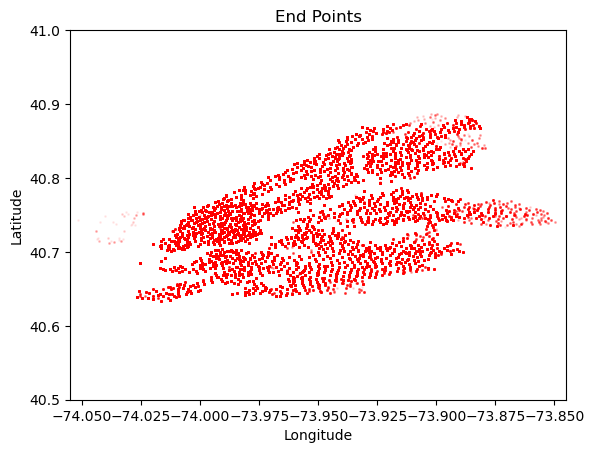

In [98]:
x = df['end_lng']
y = df['end_lat']
plt.scatter(x, y, s = 1, color = '#FF000011')
plt.xlim(-74.055,-73.845)
plt.ylim(40.5,41)
plt.title("End Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Predicting Start Points

In [99]:
def add_noise(X, noise_factor=0.001):
    noisy_X = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    return noisy_X

In [100]:
features = ['time_sin','time_cos','day_sin','day_cos']
targets = ['start_lat','start_lng']

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[targets], test_size=0.2, random_state=42)

In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [105]:
'''
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
'''

In [106]:
y_train = add_noise(y_train)

In [107]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2)
])

C:\Users\ysc15\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314 (1.23 KB)

 Trainable params: 266 (1.04 KB)

 Non-trainable params: 48 (192.00 B)

In [109]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='mse')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])
model.save('model.keras')

Epoch 1/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.5247 - loss: 1.0996 - val_accuracy: 0.5023 - val_loss: 1.0005
Epoch 2/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.5322 - loss: 0.9993 - val_accuracy: 0.5440 - val_loss: 1.0003
Epoch 3/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.5363 - loss: 0.9992 - val_accuracy: 0.5126 - val_loss: 1.0003
Epoch 4/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.5290 - loss: 0.9977 - val_accuracy: 0.5397 - val_loss: 1.0006
Epoch 5/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.5359 - loss: 0.9978 - val_accuracy: 0.4892 - val_loss: 1.0007
Epoch 6/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.5319 - loss: 0.9969 - val_accuracy: 0.5315 - val_loss: 1.0004
Epoch 7/10
24926/24926 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.5346 - loss: 0.9991 - val_accuracy: 0.5581 - val_loss: 1.0003


In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model.keras')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Predicing End Points

In [ ]:
features = ['start_lat','start_lng']
targets = ['end_lat','end_lng']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[targets], test_size=0.2, random_state=42)

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2)
])

In [ ]:
model2.compile(optimizer='adam',metrics=['accuracy'],loss='mse')
model2.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

In [ ]:
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])